In [70]:
import sys
import pandas as pd
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [4]:
def _variable_on_cpu(name, shape, initializer):
    """Helper to create a Variable stored on CPU memory.
    Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
    Returns:
    Variable Tensor
    """
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer)
    return var
def _variable_with_weight_decay(name, shape, stddev, wd, mean = 0.0):
    """Helper to create an initialized Variable with weight decay.
    Note that the Variable is initialized with a truncated normal distribution.
    A weight decay is added only if one is specified.
    Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.
    Returns:
    Variable Tensor
    """
    var = _variable_on_cpu(name, shape,
                         tf.truncated_normal_initializer(mean = mean, stddev=stddev))
    if wd:
        weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [172]:
from tflearn import tflearn, vardict

class tflasso(tflearn):
    def _create_network(self):
        c1d = 8
        c2d = 16
        k1 = 5
        k2 = 3
        self.vars = vardict()
        self.vars.xx = tf.placeholder("float", shape=[None, self.xlen])
        self.vars.yy = tf.placeholder("float", shape=[None, 1])
        
        #def fully_connected():
            
        # Create Model
        x_images = tf.reshape(self.vars.xx, [-1, 1, self.xlen//2, 2])
        # print("x_images", x_images.get_shape())
        
        with tf.variable_scope('conv1') as scope:
            self.parameters["c1_kernel"] = _variable_with_weight_decay('weights', shape=[1, k1, 2, c1d],
                                                 stddev=1e-5, wd=0.0, mean = 1e-4)
            conv = tf.nn.conv2d(x_images, self.parameters.c1_kernel, [1, 1, 1, 1], padding='SAME')
            self.parameters["c1_biases"] = _variable_on_cpu('biases', [c1d], tf.constant_initializer(0.0))
            bias = tf.nn.bias_add(conv, self.parameters.c1_biases)
            conv1 = tf.nn.relu(bias, name=scope.name)
            #_activation_summary(conv1)
        
        # pool1
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 1, 3, 1], strides=[1, 1, 2, 1],
                                 padding='SAME', name='pool1')
            
        # norm1
        norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha= 1e-5, beta=0.75,
                             name='norm1')
        # conv2
        with tf.variable_scope('conv2') as scope:
            self.parameters["c2_kernel"] = _variable_with_weight_decay('weights', shape=[1, k2, c1d, c2d],
                                                 stddev=1e-5, wd=0.0, mean = 1e-4)
            conv = tf.nn.conv2d(norm1, self.parameters.c2_kernel, [1, 1, 1, 1], padding='SAME')
            self.parameters["c2_biases"] = _variable_on_cpu('biases', [c2d], tf.constant_initializer(0.1))
            bias = tf.nn.bias_add(conv, self.parameters.c2_biases)
            conv2 = tf.nn.relu(bias, name=scope.name)
            #_activation_summary(conv2)
        # pool2
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 1, 7, 1],
                                strides=[1, 1, 2, 1], padding='SAME', name='pool2')
#         # norm2
        norm2 = tf.nn.lrn(pool2, 4, bias=1.0,  alpha= 1e-5, beta=0.75,
                             name='norm2')

        if self.train:
            self.vars.keep_prob = tf.placeholder("float")
            norm2 = tf.nn.dropout(norm2, self.vars.keep_prob)
        
        # local3
        with tf.variable_scope('local3') as scope:
            # Move everything into depth so we can perform a single matrix multiply.
            dim = 1
            for d in pool2.get_shape()[1:].as_list():
                dim *= d
            reshaped = tf.reshape(norm2, [-1, dim])
            self.parameters["l1_weights"] = _variable_with_weight_decay('weights', shape=[dim, self.xlen],
                                                  stddev= 2/np.sqrt(dim), wd=0.0004)
            self.parameters["l1_biases"] = _variable_on_cpu('biases', [self.xlen], tf.constant_initializer(0.1))
            local3 = tf.nn.relu_layer(reshaped, self.parameters.l1_weights, 
                                      self.parameters.l1_biases, name=scope.name)
            #_activation_summary(local3)
            
        # local4
        with tf.variable_scope('local4') as scope:
            self.parameters.l2_weights = _variable_with_weight_decay('weights', shape=[self.xlen, 1],
                                                  stddev=  2/np.sqrt(dim), wd=0.004)
            self.parameters.l2_biases = _variable_on_cpu('biases', [1], tf.constant_initializer(0.1))
            
            self.vars.y_predicted = tf.nn.relu_layer(local3, self.parameters.l2_weights,
                                                     self.parameters.l2_biases, name=scope.name)
            #_activation_summary(local4)

#         self.parameters["W1"] = tf.Variable(tf.truncated_normal([1, self.xlen], stddev=0.1), name="weight")
#         self.parameters["b1"] = tf.Variable(tf.constant(0.1, shape=[1, 1]), name="bias")
        
        #self.vars.y_predicted = tf.matmul( self.vars.xx, tf.transpose(self.W1)) + self.b1
        self.saver = tf.train.Saver()
        return

In [6]:
datafile = "../../data/atac_tss_800_1.h5"

with pd.HDFStore(datafile) as store:
    print(store.groups())
    y_ = store["y"]
    X_ = store["X"]

[/X (Group) ''
  children := ['block0_items_level0' (VLArray), 'axis0_level1' (Array), 'block0_items_label0' (Array), 'block0_values' (Array), 'axis1_level0' (Array), 'block0_items_label1' (Array), 'axis0_level0' (VLArray), 'block0_items_level1' (Array), 'axis0_label1' (Array), 'axis0_label0' (Array), 'axis1_level1' (Array), 'axis1_label0' (Array), 'axis1_label1' (Array)], /y (Group) ''
  children := ['index_label0' (Array), 'index_level1' (Array), 'index_label1' (Array), 'values' (Array), 'index_level0' (Array)]]


In [7]:
""" transform data """
sys.path.append("..")
from transform_tss import safelog, sumstrands, groupcolumns

feature_step = 10
select = None# list(feature_step * np.arange(-2,3,1))

Xgr = groupcolumns(X_, step = feature_step, select = select)
print(Xgr.shape)
# print(Xgr.head(3))
X, y = safelog(Xgr, y_, pseudocount=1/32)

#from sklearn.preprocessing import PolynomialFeatures
#pf3 = PolynomialFeatures(degree=3)
#X3 = pf3.fit_transform(X)
trainsamples = 4000
train_X, train_Y = X[:trainsamples], y[:trainsamples].as_matrix()
print(train_X.shape)

(41881, 322)
(4000, 322)


(41881, 3202)

In [8]:
def get_labels(pf):
    return list(pf._combinations(10, degree=pf.degree,
                          interaction_only=pf.interaction_only,
                          include_bias = pf.include_bias))

In [9]:
%ls ./cnn_ckpt/

checkpoint*      model.ckpt-240*  model.ckpt-400*  model.ckpt-500*
model.ckpt-160*  model.ckpt-260*  model.ckpt-420*  model.ckpt-520*
model.ckpt-180*  model.ckpt-280*  model.ckpt-440*
model.ckpt-200*  model.ckpt-300*  model.ckpt-460*
model.ckpt-220*  model.ckpt-380*  model.ckpt-480*


In [10]:
test_X, test_Y = X[trainsamples:(2*trainsamples+1)], y[trainsamples:(2*trainsamples+1)].as_matrix()

## visualize random initial weights

train not found


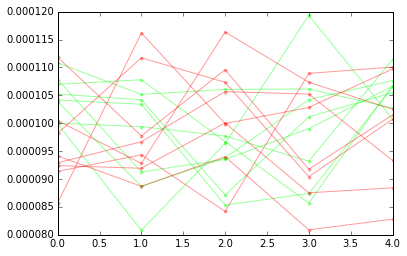

In [173]:
tfl = tflasso(ALPHA = 2e-1, display_step = 20, BATCH_SIZE = 80, dropout = 0.3,
             learning_rate = 1e-3, checkpoint_dir = "./cnn_ckpt/")
tfl.xlen = train_X.shape[1]
params = tfl.get_params(load = False)
params.keys()
plt.plot(params["c1_kernel"][0,:,0,:], "g.-", color = (0,1,0,0.4))
plt.plot(params["c1_kernel"][0,:,1,:], "r.-", color = (1,0,0,0.4))
pass

## fit

In [ ]:
tfl = tflasso(ALPHA = 2e-1, display_step = 20, BATCH_SIZE = 60, dropout = 0.3,              
             learning_rate = 1e-3, checkpoint_dir = "./cnn_ckpt/")
tfl.fit(train_X, train_Y , test_X, test_Y, load = True, training_epochs = 20000, )

variance(y) =  31.2927902671
loading a session
training epochs: 1260 ... 21260, saving each 20' epoch
  0%|          | 0/20 [00:00<?, ?it/s]

In [181]:
params = tfl.get_params(load = True)
params.keys()

loading a session


dict_keys(['c1_kernel', 'l1_biases', 'l1_weights', 'c1_biases', 'c2_biases', 'c2_kernel'])

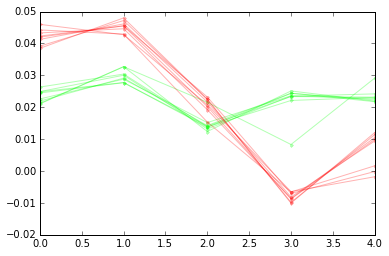

In [182]:
plt.plot(params["c1_kernel"][0,:,0,:], "g.-", color = (0,1,0,0.3))
plt.plot(params["c1_kernel"][0,:,1,:], "r.-", color = (1,0,0,0.3))
pass

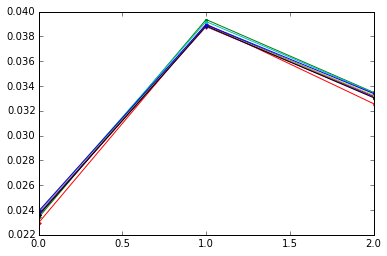

In [183]:
plt.plot(params["c2_kernel"][0,:,:,12], ".-")
pass

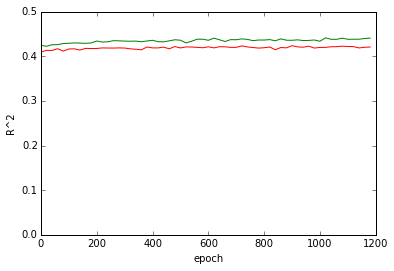

In [184]:
t_ = [x*20 for x in range(len(tfl.test_summary))]
plt.plot( t_, [x["R2"] for x in tfl.test_summary] , "r")
plt.plot( t_, [x["R2"] for x in tfl.train_summary], "g" )
plt.ylim([0, 0.1* np.ceil(10*max([x["R2"] for x in tfl.train_summary]))])
plt.ylabel("R^2")
plt.xlabel("epoch")
plt.savefig("progress.eps")

loading a session
R2: 0.4263	L2_loss: 18.6735	loss: 18.6735
/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


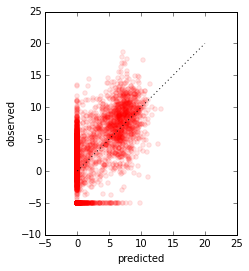

In [127]:
tfl = tflasso(checkpoint_dir = "./cnn_ckpt/", dropout = 0)
yhat = tfl.transform( test_X, test_Y, load = True)

# print( tfl.loss )
# r2 = 1 - tfl.loss/test_Y.var()
# r2
plt.scatter(yhat, test_Y, color = (1,0,0,0.1))
plt.xlabel("predicted")
plt.ylabel("observed")
plt.plot([0,20],[0,20], "k:")
plt.gca().set_aspect('equal')

In [ ]:
tfl

In [30]:
g = tf.Graph()
with g.as_default():
    tfl._create_network()
    sess_config = tf.ConfigProto(inter_op_parallelism_threads=1,
                               intra_op_parallelism_threads= 1)
    with tf.Session(config = sess_config) as sess:
        ckpt = tfl._load_(sess)
        
        print( int(ckpt.all_model_checkpoint_paths[-1].split("-")[-1]) )
        pb = ckpt.ListFields()[0][0]
        print(pb.name)

150
model_checkpoint_path


loading a session


In [ ]:
ckpt.all_model_checkpoint_paths

In [ ]:
pf3.powers_()

In [34]:
W1 = tfl.get_params()["c1_kernel"][0]
ncoef = len(W1)
xlabels = np.array( get_labels(pf3) )

forder = np.array([len(x) for x in xlabels])


fig, axs = plt.subplots(3,figsize = (14, 5))
fig.subplots_adjust(hspace=.5)
for nn in range(3):
    valid =( forder == (nn+1))
    print(sum(valid))
    x_ =  np.arange(ncoef)[valid]
    y_ = np.log10( abs(W1[valid]) )
    axs[nn].scatter(x_, y_ )
    axs[nn].scatter( x_[y_>-3], y_[y_>-3], 25, "r" )
    #axs[nn].stem( x_[y_>-3], y_[y_>-3], markerfmt = "ro" )
    if nn < 2:
        axs[nn].set_xticks(x_ )
        axs[nn].set_xticklabels([repr(x) for x in xlabels[valid]], rotation = 90)
    else:
        axs[nn].set_xticks(x_[::4] )
        axs[nn].set_xticklabels([repr(x) for x in xlabels[valid][::4]], rotation = 90)
pass

loading a session


NameError: name 'pf3' is not defined

In [ ]:
plt.stem?

In [ ]:
W1 = tfl.get_params()["W1"][0]
print(len(W1))
plt.stem( np.arange(len(W1)), np.log10( abs(W1)) )
plt.stem( np.arange(len(W1))[np.log10(W1)>-3], np.log10(W1)[np.log10(W1)>-3], markerfmt = "ro" )

In [ ]:
W1

In [ ]:
10 + 10*11/2 + 10*11*12/6

In [ ]:
tfl.fit( train_X, train_Y , load = True)

In [ ]:
tfl.fit( train_X, train_Y , load = True)

In [ ]:
checkpoint_dir = ""

saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
NUM_CORES = 3  # Choose how many cores to use.
sess_config = tf.ConfigProto(inter_op_parallelism_threads=NUM_CORES,
                                                   intra_op_parallelism_threads=NUM_CORES)
with tf.Session(config= sess_config) as sess:
    if ckpt and ckpt.model_checkpoint_path:
        ckpt.model_checkpoint_path  = './model.ckpt-1300'
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        raise Exception("...no checkpoint found...")